# Trace Clustering in Process Mining

## Importing librarires

In [1]:
import pm4py
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter("ignore")

In [2]:
from pm4py.objects.log.log import EventLog


## Importing log
Importing event log of RoadTraffic. It is in XES format with 51 traces.

In [3]:
# Importing a XES event log
from pm4py.objects.log.importer.xes import importer as xes_importer
log = xes_importer.apply('DataSets/Repair.xes')
#log[1],type(log)

parsing log, completed traces :: 100%|██████████| 1104/1104 [00:00<00:00, 1523.65it/s]


## Petrinet from Alpha miner on complete log

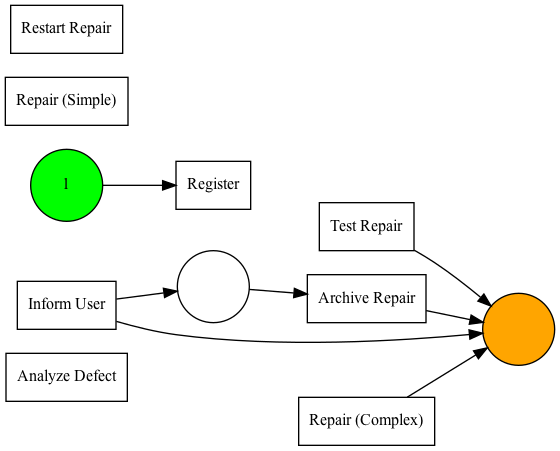

In [4]:
## Import the petrinet visualizer object
from pm4py.algo.discovery.alpha import algorithm as alpha_miner
net, initial_marking, final_marking = alpha_miner.apply(log)
from pm4py.visualization.petrinet import visualizer as pn_visualizer
# Visualise 
gviz = pn_visualizer.apply(net, initial_marking, final_marking) 
pn_visualizer.view(gviz)

## Log Fitness

In [5]:
from pm4py.algo.discovery.alpha import algorithm as alpha_miner
net, im, fm = alpha_miner.apply(log)
from pm4py.algo.evaluation.replay_fitness import algorithm as replay_fitness_evaluator
fitness = replay_fitness_evaluator.apply(log, net, im, fm, variant=replay_fitness_evaluator.Variants.TOKEN_BASED)
from pm4py.algo.evaluation.precision import algorithm as precision_evaluator
prec = precision_evaluator.apply(log, net, im, fm, variant=precision_evaluator.Variants.ETCONFORMANCE_TOKEN)
#prec
#fitness, type(fitness)
print('Fitness of log is: ', fitness['log_fitness']*100,'%')
print('Precision of log is: ', prec*100,'%')

replaying log with TBR, completed variants :: 100%|██████████| 233/233 [00:00<00:00, 1022.06it/s]

Fitness of log is:  68.28336942892967 %
Precision of log is:  23.940950770631463 %


### Extracting total Activities

In [6]:
from pm4py.algo.filtering.log.attributes import attributes_filter
activities = attributes_filter.get_attribute_values(log, "concept:name")
resources = attributes_filter.get_attribute_values(log, "org:resource")
activities,resources

({'Register': 1104,
  'Analyze Defect': 2208,
  'Repair (Complex)': 1449,
  'Test Repair': 3016,
  'Inform User': 1102,
  'Archive Repair': 1000,
  'Repair (Simple)': 1570,
  'Restart Repair': 406},
 {'System': 3612,
  'Tester3': 910,
  'SolverC1': 534,
  'Tester2': 904,
  'SolverS1': 592,
  'Tester6': 876,
  'SolverS2': 498,
  'Tester4': 788,
  'Tester1': 902,
  'SolverS3': 480,
  'SolverC3': 401,
  'Tester5': 844,
  'SolverC2': 514})

### Converting Resource keys in to a list

In [7]:
resources_array = resources.keys()
resources_array = list(resources_array)
resources_array


['System',
 'Tester3',
 'SolverC1',
 'Tester2',
 'SolverS1',
 'Tester6',
 'SolverS2',
 'Tester4',
 'Tester1',
 'SolverS3',
 'SolverC3',
 'Tester5',
 'SolverC2']

### Getting activities of each Trace in a Dataframe

In [17]:
log[0]

{'attributes': {'concept:name': '1', 'description': 'Simulated process instance'}, 'events': [{'org:resource': 'System', 'time:timestamp': datetime.datetime(1970, 1, 2, 12, 23, tzinfo=datetime.timezone(datetime.timedelta(seconds=3600))), 'concept:name': 'Register', 'lifecycle:transition': 'complete', 'case:concept:name': '1', 'case:description': 'Simulated process instance'}, '..', {'numberRepairs': '0', 'org:resource': 'System', 'lifecycle:transition': 'complete', 'time:timestamp': datetime.datetime(1970, 1, 2, 13, 10, tzinfo=datetime.timezone(datetime.timedelta(seconds=3600))), 'concept:name': 'Archive Repair', 'defectFixed': 'true', 'case:concept:name': '1', 'case:description': 'Simulated process instance'}]}

In [20]:
## Converting log in to a pandas dataframe
data = pd.read_csv('Datasets/Repair.csv')
#dataframe.to_csv('log.csv')
#dataframe
## Trace profiling on Activities
#data
dataframe =data[['Case ID','Resource']]
dataframe.head(10)

,Case ID,Resource
0,1,System
1,1,Tester3
2,1,SolverC1
3,1,Tester3
4,1,System
5,1,System
6,10,System
7,10,Tester2
8,10,SolverS1
9,10,Tester6


### Making np_array from Dataframe and grouping them on the basis of case identifier

In [123]:
np_arr = np.array(dataframe)
#np_arr
n = np.unique(np_arr[:,0])
events = np.array( [(np_arr[np_arr[:,0]==i,1]) for i in n] )
events

array([array(['Register', 'Analyze Defect', 'Repair (Complex)', 'Test Repair',
              'Inform User', 'Archive Repair'], dtype=object)                 ,
       array(['Register', 'Analyze Defect', 'Inform User', 'Repair (Complex)',
              'Test Repair', 'Archive Repair'], dtype=object)                 ,
       array(['Register', 'Analyze Defect', 'Repair (Simple)', 'Inform User',
              'Test Repair', 'Archive Repair'], dtype=object)                ,
       ...,
       array(['Register', 'Analyze Defect', 'Repair (Complex)', 'Test Repair',
              'Inform User', 'Restart Repair', 'Repair (Complex)', 'Test Repair'],
             dtype=object)                                                        ,
       array(['Register', 'Analyze Defect', 'Inform User', 'Repair (Simple)',
              'Test Repair', 'Restart Repair', 'Repair (Simple)', 'Test Repair'],
             dtype=object)                                                       ,
       array(['Register'

## 2d Vector of Number of CASES X Number of Activities

In [22]:
length  = len(log)
width = len(resources)
length,width
vectors  = [ [0] * width for _ in range(length)]
type(vectors),len(vectors)
vectors

[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

## Activities Profiling - Updating Vector with the count of occurence of Activities

In [23]:
for i in range(len(events)):
        for j in range(len(events[i])):
                if events[i][j] == resources_array[0]:
                    vectors[i][0] += 1
                elif events[i][j] == resources_array[1]:
                    vectors[i][1] += 1
                elif events[i][j] == resources_array[2]:
                    vectors[i][2] += 1
                elif events[i][j] == resources_array[3]:
                    vectors[i][3] += 1
                elif events[i][j] == resources_array[4]:
                    vectors[i][4] += 1
                elif events[i][j] == resources_array[5]:
                    vectors[i][5] += 1
                elif events[i][j] == resources_array[6]:
                    vectors[i][6] += 1
                elif events[i][j] == resources_array[7]:
                    vectors[i][7] += 1
                elif events[i][j] == resources_array[8]:
                    vectors[i][8] += 1
                elif events[i][j] == resources_array[9]:
                    vectors[i][9] += 1
                elif events[i][j] == resources_array[10]:
                    vectors[i][10] += 1
                elif events[i][j] == resources_array[11]:
                    vectors[i][11] += 1
                elif events[i][j] == resources_array[12]:
                    vectors[i][12] += 1

### Making ND-Array of the Activity Vector

In [25]:
np_vectors = np.array(vectors)
np_vectors

array([[3, 2, 1, ..., 0, 0, 0],
       [3, 0, 0, ..., 1, 0, 0],
       [3, 1, 0, ..., 0, 0, 0],
       ...,
       [3, 1, 1, ..., 1, 0, 0],
       [3, 0, 0, ..., 0, 0, 0],
       [4, 2, 0, ..., 0, 0, 0]])

## Elbow Method to find optimal number of clusters

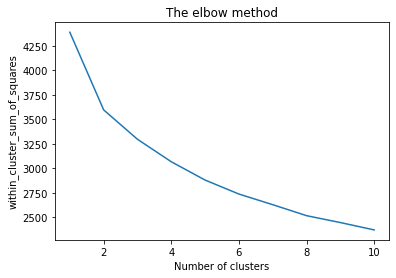

In [26]:
#  Elbow Method 
from sklearn.cluster import KMeans
within_cluster_sum_of_squares = []

for i in range(1, 11):
    kmeans = KMeans(n_clusters = i, init = 'k-means++', max_iter = 300, n_init = 10, random_state = 0)
    kmeans.fit(np_vectors)
    within_cluster_sum_of_squares.append(kmeans.inertia_)
    
#Plotting the results onto a line graph, allowing us to observe 'The elbow'
plt.plot(range(1, 11), within_cluster_sum_of_squares)
plt.title('The elbow method')
plt.xlabel('Number of clusters')
plt.ylabel('within_cluster_sum_of_squares') #within cluster sum of squares
plt.show()

# KMeans - Euclidean

In [43]:
from sklearn.cluster import KMeans
import numpy as np

kmeans = KMeans(n_clusters=5, random_state=0).fit(np_vectors)
kmeans.labels_
clustered  = kmeans.predict(np_vectors)
clustered


array([1, 4, 1, ..., 2, 2, 3], dtype=int32)

## Array of Sizes of clustered Data

In [44]:
count_arr = np.bincount(clustered)
print(count_arr)


[227 249 191 189 248]


## Creating Sub Event Logs based on Clustering Output

In [45]:
length1  = count_arr[0]
length2 = count_arr[1]
length3 = count_arr[2]
length4 = count_arr[3]
length5 = count_arr[4]

sub_log1 = EventLog()
sub_log2 = EventLog()
sub_log3 = EventLog()
sub_log4 = EventLog()
sub_log5 = EventLog()

for i in range(len(clustered)):
    if clustered[i] == 0:
        sub_log1.append(log[i])
    
    elif clustered[i] == 1:
        sub_log2.append(log[i])
        
    elif clustered[i] == 2: 
        sub_log3.append(log[i])

    elif clustered[i] == 3:
        sub_log4.append(log[i])
        
    elif clustered[i] == 4: 
        sub_log5.append(log[i])

# Petrinets from Alpha miner on Sub Event Logs

## Petrinets from Alpha miner on Sub Event Log1

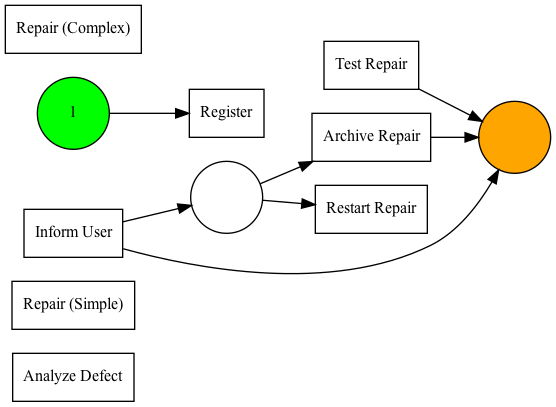

In [46]:

## Import the petrinet visualizer object
from pm4py.algo.discovery.alpha import algorithm as alpha_miner
net, initial_marking, final_marking = alpha_miner.apply(sub_log1)
from pm4py.visualization.petrinet import visualizer as pn_visualizer
# Visualise 
gviz = pn_visualizer.apply(net, initial_marking, final_marking) 
pn_visualizer.view(gviz)

## Log Fitness and Precision of SubLog1

In [47]:
from pm4py.algo.discovery.alpha import algorithm as alpha_miner
from pm4py.algo.evaluation.replay_fitness import algorithm as replay_fitness_evaluator
from pm4py.algo.evaluation.precision import algorithm as precision_evaluator
from pm4py.algo.evaluation.simplicity import algorithm as simplicity_evaluator
net, im, fm = alpha_miner.apply(sub_log1)
fitness = replay_fitness_evaluator.apply(sub_log1, net, im, fm, variant=replay_fitness_evaluator.Variants.TOKEN_BASED)
simp = simplicity_evaluator.apply(net)
prec = precision_evaluator.apply(sub_log1, net, im, fm, variant=precision_evaluator.Variants.ETCONFORMANCE_TOKEN)
print('Fitness of Petrinet is: ', fitness['log_fitness']*100,'%')
print('Precision of Petrinet is: ', prec*100,'%')
print('Simplicity of Petrinet is: ', simp*100,'%')
#prec

replaying log with TBR, completed variants :: 100%|██████████| 182/182 [00:00<00:00, 1187.18it/s]

Fitness of Petrinet is:  67.04820519500255 %
Precision of Petrinet is:  26.69306277324095 %
Simplicity of Petrinet is:  100.0 %


## Petrinets from Alpha miner on Sub Event Log2

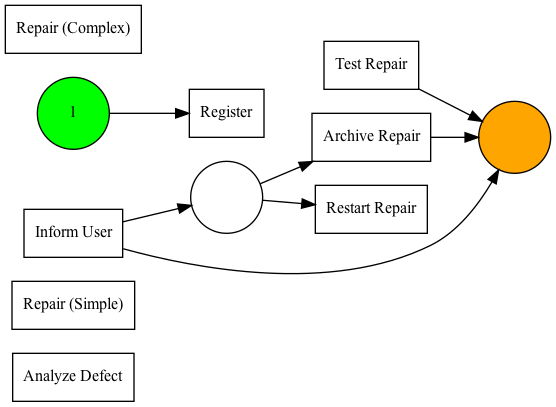

In [48]:

## Import the petrinet visualizer object
from pm4py.algo.discovery.alpha import algorithm as alpha_miner
net, initial_marking, final_marking = alpha_miner.apply(sub_log2)
from pm4py.visualization.petrinet import visualizer as pn_visualizer
# Visualise 
gviz = pn_visualizer.apply(net, initial_marking, final_marking) 
pn_visualizer.view(gviz)

## Log Fitness and Precision of SubLog2

In [49]:

net, im, fm = alpha_miner.apply(sub_log2)
fitness = replay_fitness_evaluator.apply(sub_log2, net, im, fm, variant=replay_fitness_evaluator.Variants.TOKEN_BASED)
simp = simplicity_evaluator.apply(net)
prec = precision_evaluator.apply(sub_log2, net, im, fm, variant=precision_evaluator.Variants.ETCONFORMANCE_TOKEN)
print('Fitness of Petrinet is: ', fitness['log_fitness']*100,'%')
print('Precision of Petrinet is: ', prec*100,'%')
print('Simplicity of Petrinet is: ', simp*100,'%')
#prec

replaying log with TBR, completed variants :: 100%|██████████| 156/156 [00:00<00:00, 842.59it/s]

Fitness of Petrinet is:  65.94718791019426 %
Precision of Petrinet is:  25.060329067641685 %
Simplicity of Petrinet is:  100.0 %


## Petrinets from Alpha miner on Sub Event Log3

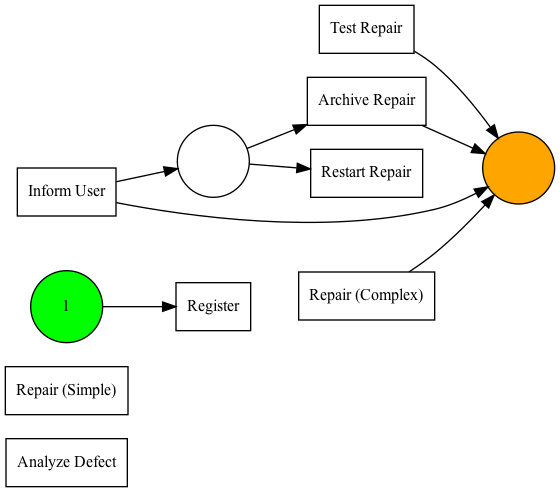

In [50]:

## Import the petrinet visualizer object
from pm4py.algo.discovery.alpha import algorithm as alpha_miner
net, initial_marking, final_marking = alpha_miner.apply(sub_log3)
from pm4py.visualization.petrinet import visualizer as pn_visualizer
# Visualise 
gviz = pn_visualizer.apply(net, initial_marking, final_marking) 
pn_visualizer.view(gviz)

## Log Fitness and Precision of Sub event log

In [51]:
net, im, fm = alpha_miner.apply(sub_log3)
fitness = replay_fitness_evaluator.apply(sub_log3, net, im, fm, variant=replay_fitness_evaluator.Variants.TOKEN_BASED)
simp = simplicity_evaluator.apply(net)
prec = precision_evaluator.apply(sub_log3, net, im, fm, variant=precision_evaluator.Variants.ETCONFORMANCE_TOKEN)
print('Fitness of Petrinet is: ', fitness['log_fitness']*100,'%')
print('Precision of Petrinet is: ', prec*100,'%')
print('Simplicity of Petrinet is: ', simp*100,'%')

replaying log with TBR, completed variants :: 100%|██████████| 153/153 [00:00<00:00, 1017.99it/s]

Fitness of Petrinet is:  63.21028268961082 %
Precision of Petrinet is:  25.357853825007115 %
Simplicity of Petrinet is:  100.0 %


# DB SCAN

## Hamming Distance

In [64]:
from sklearn.cluster import DBSCAN
clustering_DB_Hamm = DBSCAN(eps=0.16, min_samples=10, metric ='hamming').fit(np_vectors)


clustering_DB_Hamm = clustering_DB_Hamm.fit_predict(np_vectors)
clustering_DB_Hamm
# clustered = clustering.labels_
# clustered


array([ 0,  0,  0, ...,  0,  0, -1])

### Size of Clusters

In [66]:
# Removing Negative values by scaling by 1
for i in range(len(clustering_DB_Hamm)):
    clustering_DB_Hamm[i]=clustering_DB_Hamm[i]+1

In [67]:
count_arr_DB1 = np.bincount(clustering_DB_Hamm)
print(count_arr_DB1)


[130 960  14]


## Creating Sub Event Logs based on Clustering Output

In [68]:
length1  = count_arr_DB1[0]
length2 = count_arr_DB1[1]
length3 = count_arr_DB1[2]
#length4 = count_arr_DB1[3]

sub_log1_DB1 = EventLog()
sub_log2_DB1 = EventLog()
sub_log3_DB1 = EventLog()
#sub_log4_DB1 = EventLog()

for i in range(len(clustering_DB_Hamm)):
    if clustering_DB_Hamm[i] == 0:
        sub_log1_DB1.append(log[i])
    
    elif clustering_DB_Hamm[i] == 1:
        sub_log2_DB1.append(log[i])
        
    elif clustering_DB_Hamm[i] == 2: 
        sub_log3_DB1.append(log[i])

    # elif clustering_DB_Hamm[i] == 3: 
    #     sub_log4_DB1.append(log[i])

 

## Petrinets from Alpha miner on Sub Event Logs generated from DB Scan Hamming Distance

### Petrinets from Alpha miner on Sub Event Log1

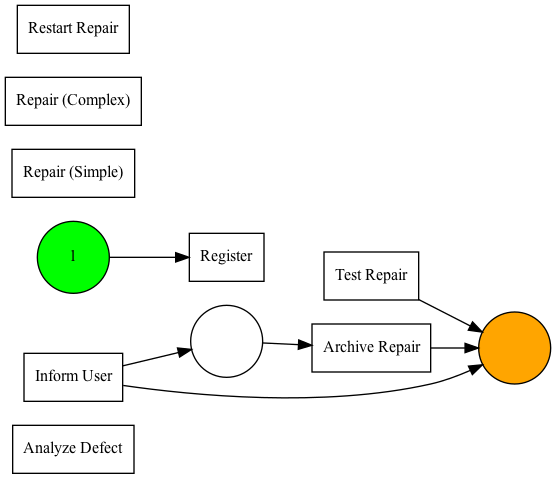

In [69]:

## Import the petrinet visualizer object
from pm4py.algo.discovery.alpha import algorithm as alpha_miner
net, initial_marking, final_marking = alpha_miner.apply(sub_log1_DB1)
from pm4py.visualization.petrinet import visualizer as pn_visualizer
# Visualise 
gviz = pn_visualizer.apply(net, initial_marking, final_marking) 
pn_visualizer.view(gviz)

## Log Fitness and Precision of SubLog1

In [70]:
net, im, fm = alpha_miner.apply(sub_log1_DB1)
fitness = replay_fitness_evaluator.apply(sub_log1_DB1, net, im, fm, variant=replay_fitness_evaluator.Variants.TOKEN_BASED)
simp = simplicity_evaluator.apply(net)
prec = precision_evaluator.apply(sub_log1_DB1, net, im, fm, variant=precision_evaluator.Variants.ETCONFORMANCE_TOKEN)
print('Fitness of Petrinet is: ', fitness['log_fitness']*100,'%')
print('Precision of Petrinet is: ', prec*100,'%')
print('Simplicity of Petrinet is: ', simp*100,'%')

replaying log with TBR, completed variants :: 100%|██████████| 178/178 [00:00<00:00, 873.02it/s]

Fitness of Petrinet is:  71.42857142857143 %
Precision of Petrinet is:  22.941671930932827 %
Simplicity of Petrinet is:  100.0 %


## Petrinets from Alpha miner on Sub Event Log2

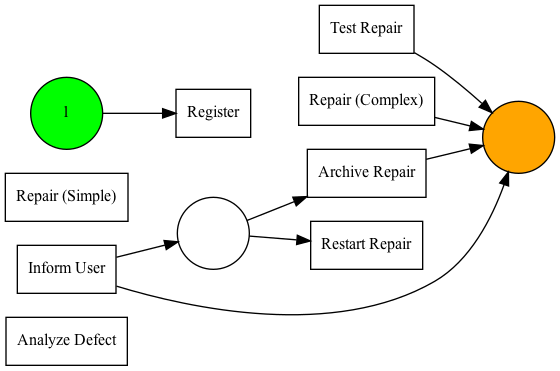

In [71]:

## Import the petrinet visualizer object
from pm4py.algo.discovery.alpha import algorithm as alpha_miner
net, initial_marking, final_marking = alpha_miner.apply(sub_log2_DB1)
from pm4py.visualization.petrinet import visualizer as pn_visualizer
# Visualise 
gviz = pn_visualizer.apply(net, initial_marking, final_marking) 
pn_visualizer.view(gviz)

## Log Fitness and Precision of SubLog2

In [72]:
net, im, fm = alpha_miner.apply(sub_log2_DB1)
fitness = replay_fitness_evaluator.apply(sub_log2_DB1, net, im, fm, variant=replay_fitness_evaluator.Variants.TOKEN_BASED)
simp = simplicity_evaluator.apply(net)
prec = precision_evaluator.apply(sub_log2_DB1, net, im, fm, variant=precision_evaluator.Variants.ETCONFORMANCE_TOKEN)
print('Fitness of Petrinet is: ', fitness['log_fitness']*100,'%')
print('Precision of Petrinet is: ', prec*100,'%')
print('Simplicity of Petrinet is: ', simp*100,'%')

replaying log with TBR, completed variants :: 100%|██████████| 219/219 [00:00<00:00, 1035.79it/s]

Fitness of Petrinet is:  63.28291550672325 %
Precision of Petrinet is:  26.617499807440502 %
Simplicity of Petrinet is:  100.0 %


## Petrinets from Alpha miner on Sub Event Log3

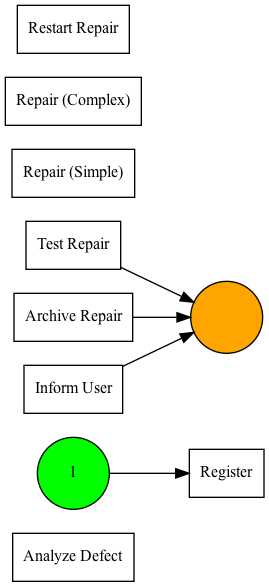

In [73]:

## Import the petrinet visualizer object
from pm4py.algo.discovery.alpha import algorithm as alpha_miner
net, initial_marking, final_marking = alpha_miner.apply(sub_log3_DB1)
from pm4py.visualization.petrinet import visualizer as pn_visualizer
# Visualise 
gviz = pn_visualizer.apply(net, initial_marking, final_marking) 
pn_visualizer.view(gviz)

## Log Fitness and Precision of Sub Event log 3

In [74]:
net, im, fm = alpha_miner.apply(sub_log3_DB1)
fitness = replay_fitness_evaluator.apply(sub_log3_DB1, net, im, fm, variant=replay_fitness_evaluator.Variants.TOKEN_BASED)
simp = simplicity_evaluator.apply(net)
prec = precision_evaluator.apply(sub_log3_DB1, net, im, fm, variant=precision_evaluator.Variants.ETCONFORMANCE_TOKEN)
print('Fitness of Petrinet is: ', fitness['log_fitness']*100,'%')
print('Precision of Petrinet is: ', prec*100,'%')
print('Simplicity of Petrinet is: ', simp*100,'%')

replaying log with TBR, completed variants :: 100%|██████████| 62/62 [00:00<00:00, 1549.49it/s]

Fitness of Petrinet is:  67.5 %
Precision of Petrinet is:  18.681318681318682 %
Simplicity of Petrinet is:  100.0 %


# DB Scan 
## Euclidean Distance

In [81]:
from sklearn.cluster import DBSCAN
clustering_DB_Euclidean = DBSCAN(eps=1.6, min_samples=10, metric ='euclidean').fit(np_vectors)


clustering_DB_Euclidean = clustering_DB_Euclidean.fit_predict(np_vectors)
clustering_DB_Euclidean
# clustered = clustering.labels_
# clustered


array([ 0,  0,  0, ...,  0,  0, -1])

### Size of Clusters

In [83]:
# Removing Negative values by scaling by 1
for i in range(len(clustering_DB_Euclidean)):
    clustering_DB_Euclidean[i]=clustering_DB_Euclidean[i]+1

In [84]:
count_arr_DB2 = np.bincount(clustering_DB_Euclidean)
print(count_arr_DB2)


[133 957  14]


## Creating Sub Event Logs based on Clustering Output

In [85]:
length1  = count_arr_DB2[0]
length2 = count_arr_DB2[1]
length3 = count_arr_DB2[2]
#length4 = count_arr_DB2[3]
# length5 = count_arr_DB2[4]

sub_log1_DB2 = EventLog()
sub_log2_DB2 = EventLog()
sub_log3_DB2 = EventLog()
#sub_log4_DB2 = EventLog()
# sub_log5_DB2 = EventLog()

for i in range(len(clustering_DB_Euclidean)):
    if clustering_DB_Euclidean[i] == 0:
        sub_log1_DB2.append(log[i])
    
    elif clustering_DB_Euclidean[i] == 1:
        sub_log2_DB2.append(log[i])
        
    elif clustering_DB_Euclidean[i] == 2: 
        sub_log3_DB2.append(log[i])
        
    # elif clustering_DB_Euclidean[i] == 3: 
    #     sub_log4_DB2.append(log[i])


## Petrinets from Alpha miner on Sub Event Logs generated from DB Scan Euclidean Distance

### Petrinets from Alpha miner on Sub Event Log1

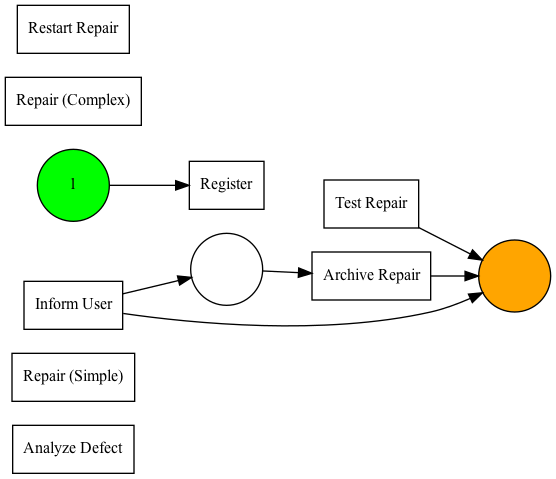

In [86]:

## Import the petrinet visualizer object
from pm4py.algo.discovery.alpha import algorithm as alpha_miner
net, initial_marking, final_marking = alpha_miner.apply(sub_log1_DB2)
from pm4py.visualization.petrinet import visualizer as pn_visualizer
# Visualise 
gviz = pn_visualizer.apply(net, initial_marking, final_marking) 
pn_visualizer.view(gviz)

## Log Fitness and Precision of SubLog1

In [87]:
net, im, fm = alpha_miner.apply(sub_log1_DB2)
fitness = replay_fitness_evaluator.apply(sub_log1_DB2, net, im, fm, variant=replay_fitness_evaluator.Variants.TOKEN_BASED)
simp = simplicity_evaluator.apply(net)
prec = precision_evaluator.apply(sub_log1_DB2, net, im, fm, variant=precision_evaluator.Variants.ETCONFORMANCE_TOKEN)
print('Fitness of Petrinet is: ', fitness['log_fitness']*100,'%')
print('Precision of Petrinet is: ', prec*100,'%')
print('Simplicity of Petrinet is: ', simp*100,'%')

replaying log with TBR, completed variants :: 100%|██████████| 178/178 [00:00<00:00, 958.18it/s] 

Fitness of Petrinet is:  71.45214521452145 %
Precision of Petrinet is:  22.954873274263342 %
Simplicity of Petrinet is:  100.0 %


## Petrinets from Alpha miner on Sub Event Log2

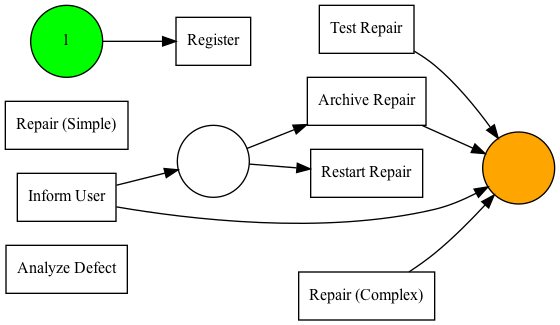

In [88]:

## Import the petrinet visualizer object
from pm4py.algo.discovery.alpha import algorithm as alpha_miner
net, initial_marking, final_marking = alpha_miner.apply(sub_log2_DB2)
from pm4py.visualization.petrinet import visualizer as pn_visualizer
# Visualise 
gviz = pn_visualizer.apply(net, initial_marking, final_marking) 
pn_visualizer.view(gviz)

## Log Fitness and Precision of SubLog2

In [89]:
net, im, fm = alpha_miner.apply(sub_log2_DB2)
fitness = replay_fitness_evaluator.apply(sub_log2_DB2, net, im, fm, variant=replay_fitness_evaluator.Variants.TOKEN_BASED)
simp = simplicity_evaluator.apply(net)
prec = precision_evaluator.apply(sub_log2_DB2, net, im, fm, variant=precision_evaluator.Variants.ETCONFORMANCE_TOKEN)
print('Fitness of Petrinet is: ', fitness['log_fitness']*100,'%')
print('Precision of Petrinet is: ', prec*100,'%')
print('Simplicity of Petrinet is: ', simp*100,'%')

replaying log with TBR, completed variants :: 100%|██████████| 219/219 [00:00<00:00, 1198.04it/s]

Fitness of Petrinet is:  63.2765519433367 %
Precision of Petrinet is:  26.61681448418449 %
Simplicity of Petrinet is:  100.0 %


## Petrinets from Alpha miner on Sub Event Log3

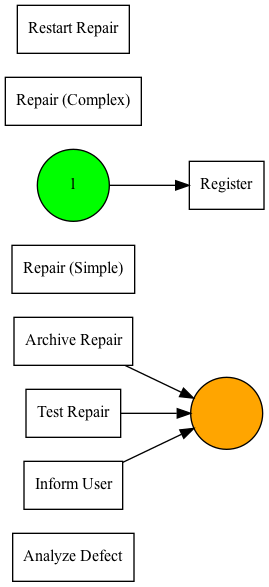

In [90]:

## Import the petrinet visualizer object
from pm4py.algo.discovery.alpha import algorithm as alpha_miner
net, initial_marking, final_marking = alpha_miner.apply(sub_log3_DB2)
from pm4py.visualization.petrinet import visualizer as pn_visualizer
# Visualise 
gviz = pn_visualizer.apply(net, initial_marking, final_marking) 
pn_visualizer.view(gviz)

## Log Fitness and Precision of Sub Event log 3

In [91]:
net, im, fm = alpha_miner.apply(sub_log3_DB2)
fitness = replay_fitness_evaluator.apply(sub_log3_DB2, net, im, fm, variant=replay_fitness_evaluator.Variants.TOKEN_BASED)
simp = simplicity_evaluator.apply(net)
prec = precision_evaluator.apply(sub_log3_DB2, net, im, fm, variant=precision_evaluator.Variants.ETCONFORMANCE_TOKEN)
print('Fitness of Petrinet is: ', fitness['log_fitness']*100,'%')
print('Precision of Petrinet is: ', prec*100,'%')
print('Simplicity of Petrinet is: ', simp*100,'%')

replaying log with TBR, completed variants :: 100%|██████████| 62/62 [00:00<00:00, 1440.36it/s]

Fitness of Petrinet is:  67.5 %
Precision of Petrinet is:  18.681318681318682 %
Simplicity of Petrinet is:  100.0 %


# DB Scan
## Jaccard  Distance

In [119]:
from sklearn.cluster import DBSCAN
clustering_DB_Jaccard = DBSCAN(eps=0.1, min_samples=100, metric ='jaccard').fit(np_vectors)
clustering_DB_Jaccard = clustering_DB_Jaccard.fit_predict(np_vectors)
clustering_DB_Jaccard
# clustered = clustering.labels_
# clustered

array([-1, -1, -1, ..., -1, -1, -1])

In [120]:
# Removing Negative values by scaling by 1
for i in range(len(clustering_DB_Jaccard)):
    clustering_DB_Jaccard[i]=clustering_DB_Jaccard[i]+1

In [121]:
count_arr_DB3 = np.bincount(clustering_DB_Jaccard)
print(count_arr_DB3)


[1104]


## Creating Sub Event Logs based on Clustering Output

In [ ]:
length1  = count_arr_DB3[0]
length2 = count_arr_DB3[1]
length3 = count_arr_DB3[2]
length4 = count_arr_DB2[3]
# length5 = count_arr_DB2[4]

sub_log1_DB3 = EventLog()
sub_log2_DB3 = EventLog()
sub_log3_DB3 = EventLog()
sub_log4_DB3 = EventLog()
# sub_log5_DB2 = EventLog()

for i in range(len(clustering_DB_Jaccard)):
    if clustering_DB_Jaccard[i] == 0:
        sub_log1_DB3.append(log[i])
    
    elif clustering_DB_Jaccard[i] == 1:
        sub_log2_DB3.append(log[i])
        
    elif clustering_DB_Jaccard[i] == 2: 
        sub_log3_DB3.append(log[i])
    elif clustering_DB_Jaccard[i] == 3: 
        sub_log4_DB3.append(log[i])


# Petrinets from Alpha miner on Sub Event Logs generated from DB Scan Euclidean Distance

## Petrinets from Alpha miner on Sub Event Log1

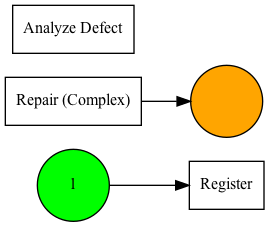

In [ ]:

## Import the petrinet visualizer object
from pm4py.algo.discovery.alpha import algorithm as alpha_miner
net, initial_marking, final_marking = alpha_miner.apply(sub_log1_DB3)
from pm4py.visualization.petrinet import visualizer as pn_visualizer
# Visualise 
gviz = pn_visualizer.apply(net, initial_marking, final_marking) 
pn_visualizer.view(gviz)

## Log Fitness and Precision of SubLog1

In [ ]:
net, im, fm = alpha_miner.apply(sub_log1_DB3)
fitness = replay_fitness_evaluator.apply(sub_log1_DB3, net, im, fm, variant=replay_fitness_evaluator.Variants.TOKEN_BASED)
simp = simplicity_evaluator.apply(net)
prec = precision_evaluator.apply(sub_log1_DB3, net, im, fm, variant=precision_evaluator.Variants.ETCONFORMANCE_TOKEN)
print('Fitness of Petrinet is: ', fitness['log_fitness']*100,'%')
print('Precision of Petrinet is: ', prec*100,'%')
print('Simplicity of Petrinet is: ', simp*100,'%')

replaying log with TBR, completed variants :: 100%|██████████| 4/4 [00:00<00:00, 2331.14it/s]

Fitness of Petrinet is:  90.0 %
Precision of Petrinet is:  44.99999999999999 %
Simplicity of Petrinet is:  100.0 %


## Petrinets from Alpha miner on Sub Event Log2

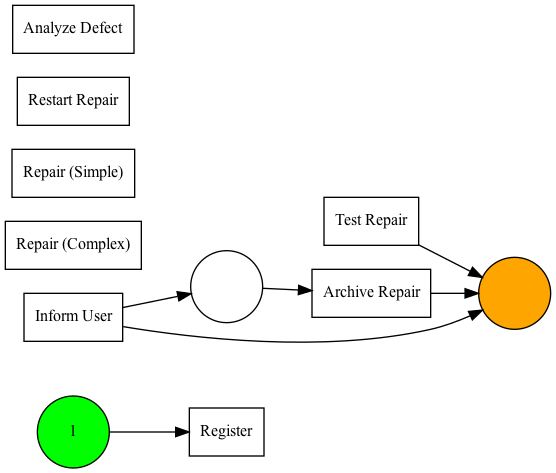

In [ ]:

## Import the petrinet visualizer object
from pm4py.algo.discovery.alpha import algorithm as alpha_miner
net, initial_marking, final_marking = alpha_miner.apply(sub_log2_DB3)
from pm4py.visualization.petrinet import visualizer as pn_visualizer
# Visualise 
gviz = pn_visualizer.apply(net, initial_marking, final_marking) 
pn_visualizer.view(gviz)

## Log Fitness and Precision of SubLog2

In [ ]:
net, im, fm = alpha_miner.apply(sub_log2_DB3)
fitness = replay_fitness_evaluator.apply(sub_log2_DB3, net, im, fm, variant=replay_fitness_evaluator.Variants.TOKEN_BASED)
simp = simplicity_evaluator.apply(net)
prec = precision_evaluator.apply(sub_log2_DB3, net, im, fm, variant=precision_evaluator.Variants.ETCONFORMANCE_TOKEN)
print('Fitness of Petrinet is: ', fitness['log_fitness']*100,'%')
print('Precision of Petrinet is: ', prec*100,'%')
print('Simplicity of Petrinet is: ', simp*100,'%')
#prec

replaying log with TBR, completed variants :: 100%|██████████| 233/233 [00:00<00:00, 1123.12it/s]

Fitness of Petrinet is:  71.97928653624857 %
Precision of Petrinet is:  23.936490555707636 %
Simplicity of Petrinet is:  100.0 %


## Petrinets from Alpha miner on Sub Event Log3

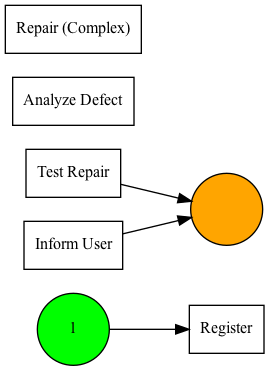

In [ ]:

## Import the petrinet visualizer object
from pm4py.algo.discovery.alpha import algorithm as alpha_miner
net, initial_marking, final_marking = alpha_miner.apply(sub_log3_DB3)
from pm4py.visualization.petrinet import visualizer as pn_visualizer
# Visualise 
gviz = pn_visualizer.apply(net, initial_marking, final_marking) 
pn_visualizer.view(gviz)

## Log Fitness and Precision of Sub Event log 3

In [ ]:
net, im, fm = alpha_miner.apply(sub_log3_DB3)
fitness = replay_fitness_evaluator.apply(sub_log3_DB3, net, im, fm, variant=replay_fitness_evaluator.Variants.TOKEN_BASED)
simp = simplicity_evaluator.apply(net)
prec = precision_evaluator.apply(sub_log3_DB3, net, im, fm, variant=precision_evaluator.Variants.ETCONFORMANCE_TOKEN)
print('Fitness of Petrinet is: ', fitness['log_fitness']*100,'%')
print('Precision of Petrinet is: ', prec*100,'%')
print('Simplicity of Petrinet is: ', simp*100,'%')

replaying log with TBR, completed variants :: 100%|██████████| 15/15 [00:00<00:00, 2467.14it/s]

Fitness of Petrinet is:  75.0 %
Precision of Petrinet is:  30.796335447498237 %
Simplicity of Petrinet is:  100.0 %


## Petrinets from Alpha miner on Sub Event Log4

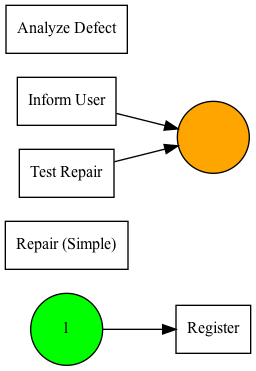

In [ ]:

## Import the petrinet visualizer object
from pm4py.algo.discovery.alpha import algorithm as alpha_miner
net, initial_marking, final_marking = alpha_miner.apply(sub_log4_DB3)
from pm4py.visualization.petrinet import visualizer as pn_visualizer
# Visualise 
gviz = pn_visualizer.apply(net, initial_marking, final_marking) 
pn_visualizer.view(gviz)

## Log Fitness and Precision of Sub Event log 3

In [ ]:
net, im, fm = alpha_miner.apply(sub_log4_DB3)
fitness = replay_fitness_evaluator.apply(sub_log4_DB3, net, im, fm, variant=replay_fitness_evaluator.Variants.TOKEN_BASED)
simp = simplicity_evaluator.apply(net)
prec = precision_evaluator.apply(sub_log4_DB3, net, im, fm, variant=precision_evaluator.Variants.ETCONFORMANCE_TOKEN)
print('Fitness of Petrinet is: ', fitness['log_fitness']*100,'%')
print('Precision of Petrinet is: ', prec*100,'%')
print('Simplicity of Petrinet is: ', simp*100,'%')

replaying log with TBR, completed variants :: 100%|██████████| 15/15 [00:00<00:00, 2124.34it/s]

Fitness of Petrinet is:  75.0 %
Precision of Petrinet is:  31.671554252199417 %
Simplicity of Petrinet is:  100.0 %


# Agglomerative Clustering
## Euclidean

In [ ]:

from sklearn.cluster import AgglomerativeClustering

clustering_Agglomerative = AgglomerativeClustering(n_clusters=3,affinity='euclidean').fit(np_vectors)
clustering_Agglomerative =clustering_Agglomerative.labels_
clustering_Agglomerative

array([0, 1, 0, ..., 0, 0, 1])

In [ ]:
count_arr_Aglomerative = np.bincount(clustering_Agglomerative)
print(count_arr_Aglomerative)


[620 242 242]


## Creating Sub Event Logs based on Clustering Output

In [ ]:
length1  = count_arr_Aglomerative[0]
length2 = count_arr_Aglomerative[1]
length3 = count_arr_Aglomerative[2]
# length4 = count_arr_DB2[3]
# length5 = count_arr_DB2[4]

sub_log1_AG = EventLog()
sub_log2_AG = EventLog()
sub_log3_AG = EventLog()
# sub_log4_DB2 = EventLog()
# sub_log5_DB2 = EventLog()

for i in range(len(clustering_Agglomerative)):
    if clustering_Agglomerative[i] == 0:
        sub_log1_AG.append(log[i])
    
    elif clustering_Agglomerative[i] == 1:
        sub_log2_AG.append(log[i])
        
    elif clustering_Agglomerative[i] == 2: 
        sub_log3_AG.append(log[i])


# Petrinets from Alpha miner on Sub Event Logs generated from DB Scan Euclidean Distance

## Petrinets from Alpha miner on Sub Event Log1

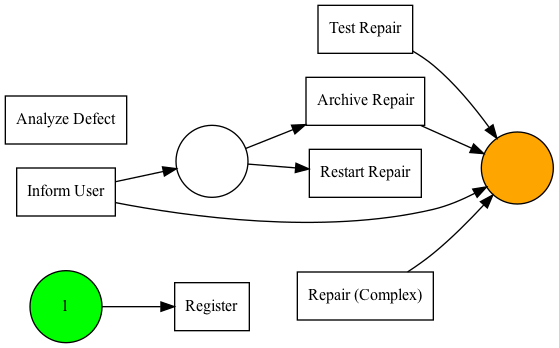

In [ ]:

## Import the petrinet visualizer object
from pm4py.algo.discovery.alpha import algorithm as alpha_miner
net, initial_marking, final_marking = alpha_miner.apply(sub_log1_AG)
from pm4py.visualization.petrinet import visualizer as pn_visualizer
# Visualise 
gviz = pn_visualizer.apply(net, initial_marking, final_marking) 
pn_visualizer.view(gviz)

## Log Fitness and Precision of SubLog1

In [ ]:
net, im, fm = alpha_miner.apply(sub_log1_AG)
fitness = replay_fitness_evaluator.apply(sub_log1_AG, net, im, fm, variant=replay_fitness_evaluator.Variants.TOKEN_BASED)
simp = simplicity_evaluator.apply(net)
prec = precision_evaluator.apply(sub_log1_AG, net, im, fm, variant=precision_evaluator.Variants.ETCONFORMANCE_TOKEN)
print('Fitness of Petrinet is: ', fitness['log_fitness']*100,'%')
print('Precision of Petrinet is: ', prec*100,'%')
print('Simplicity of Petrinet is: ', simp*100,'%')

replaying log with TBR, completed variants :: 100%|██████████| 82/82 [00:00<00:00, 1536.75it/s]

Fitness of Petrinet is:  65.82066617016824 %
Precision of Petrinet is:  28.919577579203903 %
Simplicity of Petrinet is:  100.0 %


## Petrinets from Alpha miner on Sub Event Log2

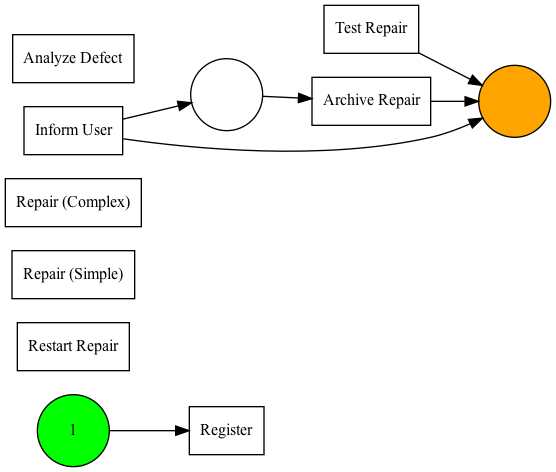

In [ ]:

## Import the petrinet visualizer object
from pm4py.algo.discovery.alpha import algorithm as alpha_miner
net, initial_marking, final_marking = alpha_miner.apply(sub_log2_AG)
from pm4py.visualization.petrinet import visualizer as pn_visualizer
# Visualise 
gviz = pn_visualizer.apply(net, initial_marking, final_marking) 
pn_visualizer.view(gviz)

## Log Fitness and Precision of SubLog2

In [ ]:
net, im, fm = alpha_miner.apply(sub_log2_AG)
fitness = replay_fitness_evaluator.apply(sub_log2_AG, net, im, fm, variant=replay_fitness_evaluator.Variants.TOKEN_BASED)
simp = simplicity_evaluator.apply(net)
prec = precision_evaluator.apply(sub_log2_AG, net, im, fm, variant=precision_evaluator.Variants.ETCONFORMANCE_TOKEN)
print('Fitness of Petrinet is: ', fitness['log_fitness']*100,'%')
print('Precision of Petrinet is: ', prec*100,'%')
print('Simplicity of Petrinet is: ', simp*100,'%')

replaying log with TBR, completed variants :: 100%|██████████| 155/155 [00:00<00:00, 905.09it/s]

Fitness of Petrinet is:  66.61918328584994 %
Precision of Petrinet is:  22.2085548765971 %
Simplicity of Petrinet is:  100.0 %


## Petrinets from Alpha miner on Sub Event Log3

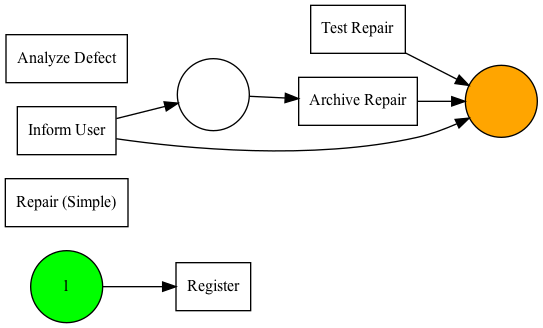

In [ ]:

## Import the petrinet visualizer object
from pm4py.algo.discovery.alpha import algorithm as alpha_miner
net, initial_marking, final_marking = alpha_miner.apply(sub_log3_AG)
from pm4py.visualization.petrinet import visualizer as pn_visualizer
# Visualise 
gviz = pn_visualizer.apply(net, initial_marking, final_marking) 
pn_visualizer.view(gviz)

## Log Fitness and Precision of Sub Event log 3

In [ ]:
net, im, fm = alpha_miner.apply(sub_log3_AG)
fitness = replay_fitness_evaluator.apply(sub_log3_AG, net, im, fm, variant=replay_fitness_evaluator.Variants.TOKEN_BASED)
simp = simplicity_evaluator.apply(net)
prec = precision_evaluator.apply(sub_log3_AG, net, im, fm, variant=precision_evaluator.Variants.ETCONFORMANCE_TOKEN)
print('Fitness of Petrinet is: ', fitness['log_fitness']*100,'%')
print('Precision of Petrinet is: ', prec*100,'%')
print('Simplicity of Petrinet is: ', simp*100,'%')

replaying log with TBR, completed variants :: 100%|██████████| 19/19 [00:00<00:00, 1607.14it/s]

Fitness of Petrinet is:  74.45460942997889 %
Precision of Petrinet is:  28.781157583438954 %
Simplicity of Petrinet is:  100.0 %


# Self Organizing Maps - SOM


[array([6, 0]), array([4, 9]), array([6, 0]), array([9, 9]), array([9, 3]), array([8, 6]), array([4, 7]), array([8, 6]), array([8, 6]), array([9, 3]), array([8, 6]), array([0, 9]), array([9, 3]), array([6, 0]), array([4, 7]), array([9, 3]), array([9, 3]), array([9, 3]), array([8, 6]), array([9, 3]), array([0, 9]), array([8, 6]), array([9, 3]), array([9, 3]), array([6, 0]), array([9, 3]), array([9, 3]), array([8, 6]), array([9, 3]), array([0, 5]), array([8, 6]), array([9, 3]), array([8, 6]), array([9, 3]), array([8, 6]), array([6, 0]), array([8, 6]), array([9, 3]), array([8, 6]), array([4, 7]), array([4, 7]), array([9, 3]), array([9, 3]), array([8, 6]), array([9, 3]), array([9, 3]), array([6, 0]), array([8, 6]), array([0, 9]), array([8, 6]), array([8, 6]), array([9, 3]), array([8, 6]), array([9, 3]), array([4, 7]), array([9, 3]), array([9, 3]), array([6, 0]), array([8, 6]), array([4, 7]), array([9, 3]), array([8, 6]), array([8, 6]), array([8, 6]), array([4, 7]), array([9, 3]), array([2,

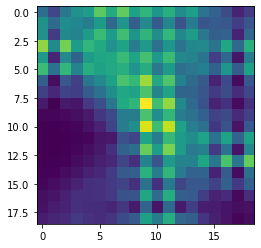

In [ ]:
import susi
import numpy as np
import matplotlib.pyplot as plt
som = susi.SOMClustering()
som.fit(np_vectors)
umat = som.get_u_matrix()
clusters = som.get_bmus(np_vectors)
print(clusters)
plt.imshow(np.squeeze(umat))

### Unique Clusters

In [ ]:
unique_clusters = np.unique(clusters, axis=0)
unique_clusters

array([[0, 0],
       [0, 5],
       [0, 9],
       [1, 0],
       [2, 4],
       [4, 7],
       [4, 9],
       [6, 0],
       [8, 6],
       [9, 3],
       [9, 4],
       [9, 9]])

## Making Sub Event Logs on the basis of SOM Clusters

In [ ]:

som_sub_log1 = EventLog()
som_sub_log2 = EventLog()
som_sub_log3 = EventLog()
som_sub_log4 = EventLog()
som_sub_log5 = EventLog()
som_sub_log6 = EventLog()
som_sub_log7 = EventLog()
som_sub_log8 = EventLog()
som_sub_log9 = EventLog()
som_sub_log10 = EventLog()
som_sub_log11 = EventLog()
som_sub_log12 = EventLog()



for i in range(len(clusters)):
    if clusters[i][0] == unique_clusters[0][0] and clusters[i][1] ==unique_clusters[0][1]:
        som_sub_log1.append(log[i])
    
    elif clusters[i][0] == unique_clusters[1][0] and clusters[i][1] ==unique_clusters[1][1]:
        som_sub_log2.append(log[i])

    elif clusters[i][0] == unique_clusters[2][0] and clusters[i][1] ==unique_clusters[2][1]:
        som_sub_log3.append(log[i])
        
    elif clusters[i][0] == unique_clusters[3][0] and clusters[i][1] ==unique_clusters[3][1]:
        som_sub_log4.append(log[i])

    elif clusters[i][0] == unique_clusters[4][0] and clusters[i][1] ==unique_clusters[4][1]:
        som_sub_log5.append(log[i])

    elif clusters[i][0] == unique_clusters[5][0] and clusters[i][1] ==unique_clusters[5][1]:
        som_sub_log6.append(log[i])

    elif clusters[i][0] == unique_clusters[6][0] and clusters[i][1] ==unique_clusters[6][1]:
        som_sub_log7.append(log[i])

    elif clusters[i][0] == unique_clusters[7][0] and clusters[i][1] ==unique_clusters[7][1]:
        som_sub_log8.append(log[i])

    elif clusters[i][0] == unique_clusters[8][0] and clusters[i][1] ==unique_clusters[8][1]:
        som_sub_log9.append(log[i])
        
    elif clusters[i][0] == unique_clusters[9][0] and clusters[i][1] ==unique_clusters[9][1]:
        som_sub_log10.append(log[i])

    elif clusters[i][0] == unique_clusters[10][0] and clusters[i][1] ==unique_clusters[10][1]:
        som_sub_log11.append(log[i])


    elif clusters[i][0] == unique_clusters[11][0] and clusters[i][1] ==unique_clusters[11][1]:
        som_sub_log12.append(log[i])


### Checking sizes of clusters

In [ ]:
len(som_sub_log1),len(som_sub_log2),len(som_sub_log3),len(som_sub_log4),len(som_sub_log5),len(som_sub_log6)

(13, 10, 88, 38, 29, 14)

In [ ]:
len(som_sub_log7),len(som_sub_log8),len(som_sub_log9),len(som_sub_log10),len(som_sub_log11),len(som_sub_log12)

(101, 524, 31, 44, 1, 211)

# Petrinets from Alpha miner on Sub Event Logs generated from SOM

## Petrinets from Alpha miner on Sub Event Log1

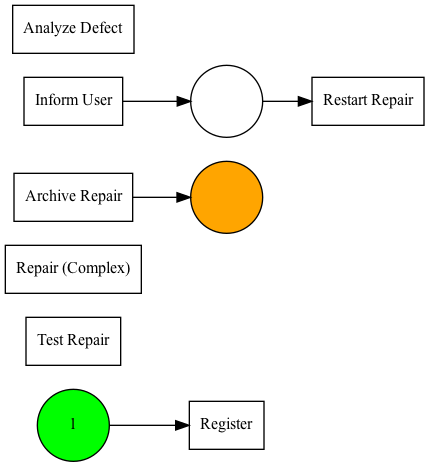

In [ ]:

## Import the petrinet visualizer object
from pm4py.algo.discovery.alpha import algorithm as alpha_miner
net, initial_marking, final_marking = alpha_miner.apply(som_sub_log1)
from pm4py.visualization.petrinet import visualizer as pn_visualizer
# Visualise 
gviz = pn_visualizer.apply(net, initial_marking, final_marking) 
pn_visualizer.view(gviz)

## Log Fitness and Precision of SubLog1

In [ ]:
net, im, fm = alpha_miner.apply(som_sub_log1)
fitness = replay_fitness_evaluator.apply(som_sub_log1, net, im, fm, variant=replay_fitness_evaluator.Variants.TOKEN_BASED)
simp = simplicity_evaluator.apply(net)
prec = precision_evaluator.apply(som_sub_log1, net, im, fm, variant=precision_evaluator.Variants.ETCONFORMANCE_TOKEN)
print('Fitness of Petrinet is: ', fitness['log_fitness']*100,'%')
print('Precision of Petrinet is: ', prec*100,'%')
print('Simplicity of Petrinet is: ', simp*100,'%')

replaying log with TBR, completed variants :: 100%|██████████| 75/75 [00:00<00:00, 1325.79it/s]

Fitness of Petrinet is:  86.11111111111111 %
Precision of Petrinet is:  20.91212458286985 %
Simplicity of Petrinet is:  100.0 %


## Petrinets from Alpha miner on Sub Event Log2

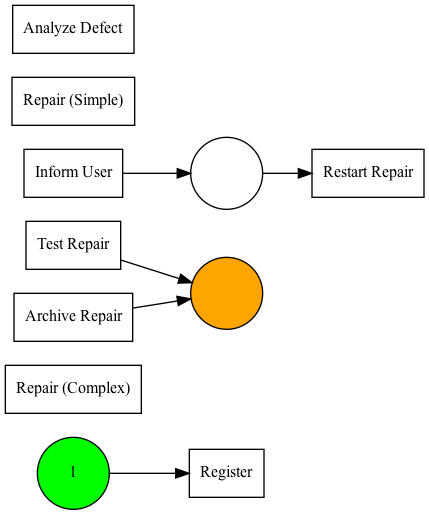

In [ ]:

## Import the petrinet visualizer object
from pm4py.algo.discovery.alpha import algorithm as alpha_miner
net, initial_marking, final_marking = alpha_miner.apply(som_sub_log2)
from pm4py.visualization.petrinet import visualizer as pn_visualizer
# Visualise 
gviz = pn_visualizer.apply(net, initial_marking, final_marking) 
pn_visualizer.view(gviz)

## Log Fitness and Precision of SubLog2

In [ ]:
net, im, fm = alpha_miner.apply(som_sub_log2)
fitness = replay_fitness_evaluator.apply(som_sub_log2, net, im, fm, variant=replay_fitness_evaluator.Variants.TOKEN_BASED)
simp = simplicity_evaluator.apply(net)
prec = precision_evaluator.apply(som_sub_log2, net, im, fm, variant=precision_evaluator.Variants.ETCONFORMANCE_TOKEN)
print('Fitness of Petrinet is: ', fitness['log_fitness']*100,'%')
print('Precision of Petrinet is: ', prec*100,'%')
print('Simplicity of Petrinet is: ', simp*100,'%')

replaying log with TBR, completed variants :: 100%|██████████| 64/64 [00:00<00:00, 1151.87it/s]

Fitness of Petrinet is:  54.35393258426966 %
Precision of Petrinet is:  17.966573816155986 %
Simplicity of Petrinet is:  100.0 %


## Petrinets from Alpha miner on Sub Event Log3

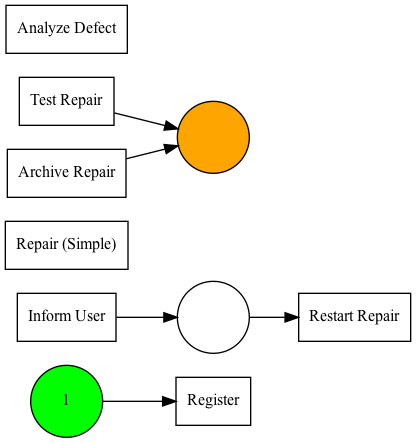

In [ ]:

## Import the petrinet visualizer object
from pm4py.algo.discovery.alpha import algorithm as alpha_miner
net, initial_marking, final_marking = alpha_miner.apply(som_sub_log3)
from pm4py.visualization.petrinet import visualizer as pn_visualizer
# Visualise 
gviz = pn_visualizer.apply(net, initial_marking, final_marking) 
pn_visualizer.view(gviz)

## Log Fitness and Precision of Sub Event log 3

In [ ]:
net, im, fm = alpha_miner.apply(som_sub_log3)
fitness = replay_fitness_evaluator.apply(som_sub_log3, net, im, fm, variant=replay_fitness_evaluator.Variants.TOKEN_BASED)
simp = simplicity_evaluator.apply(net)
prec = precision_evaluator.apply(som_sub_log3, net, im, fm, variant=precision_evaluator.Variants.ETCONFORMANCE_TOKEN)
print('Fitness of Petrinet is: ', fitness['log_fitness']*100,'%')
print('Precision of Petrinet is: ', prec*100,'%')
print('Simplicity of Petrinet is: ', simp*100,'%')

replaying log with TBR, completed variants :: 100%|██████████| 105/105 [00:00<00:00, 1386.07it/s]

Fitness of Petrinet is:  53.925092764378476 %
Precision of Petrinet is:  23.427844420210832 %
Simplicity of Petrinet is:  100.0 %


## Petrinets from Alpha miner on Sub Event Log 4

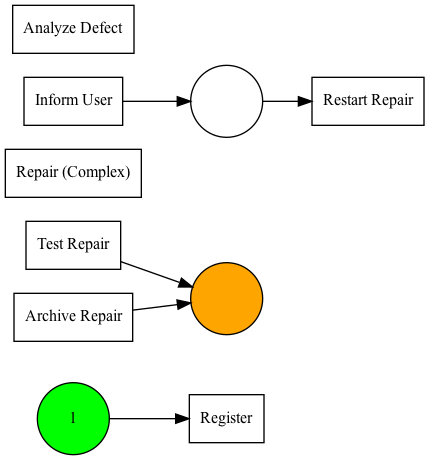

In [ ]:

## Import the petrinet visualizer object
from pm4py.algo.discovery.alpha import algorithm as alpha_miner
net, initial_marking, final_marking = alpha_miner.apply(som_sub_log4)
from pm4py.visualization.petrinet import visualizer as pn_visualizer
# Visualise 
gviz = pn_visualizer.apply(net, initial_marking, final_marking) 
pn_visualizer.view(gviz)

## Log Fitness and Precision of SubLog 4

In [ ]:
net, im, fm = alpha_miner.apply(som_sub_log4)
fitness = replay_fitness_evaluator.apply(som_sub_log4, net, im, fm, variant=replay_fitness_evaluator.Variants.TOKEN_BASED)
simp = simplicity_evaluator.apply(net)
prec = precision_evaluator.apply(som_sub_log4, net, im, fm, variant=precision_evaluator.Variants.ETCONFORMANCE_TOKEN)
print('Fitness of Petrinet is: ', fitness['log_fitness']*100,'%')
print('Precision of Petrinet is: ', prec*100,'%')
print('Simplicity of Petrinet is: ', simp*100,'%')

replaying log with TBR, completed variants :: 100%|██████████| 49/49 [00:00<00:00, 1442.28it/s]

Fitness of Petrinet is:  62.799043062200965 %
Precision of Petrinet is:  23.1457800511509 %
Simplicity of Petrinet is:  100.0 %


## Petrinets from Alpha miner on Sub Event Log 5

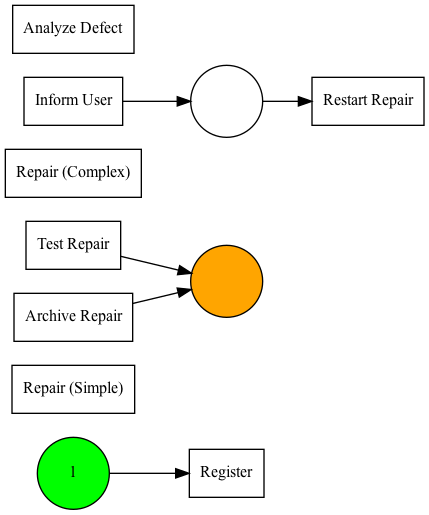

In [ ]:

## Import the petrinet visualizer object
from pm4py.algo.discovery.alpha import algorithm as alpha_miner
net, initial_marking, final_marking = alpha_miner.apply(som_sub_log5)
from pm4py.visualization.petrinet import visualizer as pn_visualizer
# Visualise 
gviz = pn_visualizer.apply(net, initial_marking, final_marking) 
pn_visualizer.view(gviz)

## Log Fitness and Precision of SubLog 5

In [ ]:
net, im, fm = alpha_miner.apply(som_sub_log5)
fitness = replay_fitness_evaluator.apply(som_sub_log5, net, im, fm, variant=replay_fitness_evaluator.Variants.TOKEN_BASED)
simp = simplicity_evaluator.apply(net)
prec = precision_evaluator.apply(som_sub_log5, net, im, fm, variant=precision_evaluator.Variants.ETCONFORMANCE_TOKEN)
print('Fitness of Petrinet is: ', fitness['log_fitness']*100,'%')
print('Precision of Petrinet is: ', prec*100,'%')
print('Simplicity of Petrinet is: ', simp*100,'%')

replaying log with TBR, completed variants :: 100%|██████████| 49/49 [00:00<00:00, 1425.04it/s]

Fitness of Petrinet is:  60.20402298850575 %
Precision of Petrinet is:  19.819819819819816 %
Simplicity of Petrinet is:  100.0 %


## Petrinets from Alpha miner on Sub Event Log 6

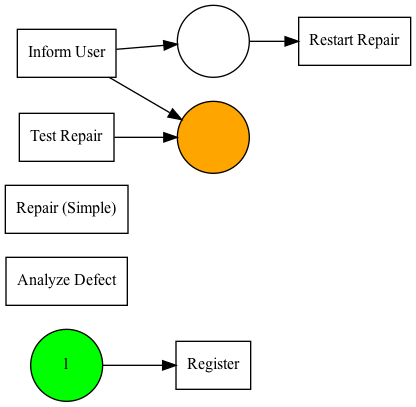

In [ ]:

## Import the petrinet visualizer object
from pm4py.algo.discovery.alpha import algorithm as alpha_miner
net, initial_marking, final_marking = alpha_miner.apply(som_sub_log6)
from pm4py.visualization.petrinet import visualizer as pn_visualizer
# Visualise 
gviz = pn_visualizer.apply(net, initial_marking, final_marking) 
pn_visualizer.view(gviz)

## Log Fitness and Precision of SubLog 6

In [ ]:
net, im, fm = alpha_miner.apply(som_sub_log6)
fitness = replay_fitness_evaluator.apply(som_sub_log6, net, im, fm, variant=replay_fitness_evaluator.Variants.TOKEN_BASED)
simp = simplicity_evaluator.apply(net)
prec = precision_evaluator.apply(som_sub_log6, net, im, fm, variant=precision_evaluator.Variants.ETCONFORMANCE_TOKEN)
print('Fitness of Petrinet is: ', fitness['log_fitness']*100,'%')
print('Precision of Petrinet is: ', prec*100,'%')
print('Simplicity of Petrinet is: ', simp*100,'%')

replaying log with TBR, completed variants :: 100%|██████████| 43/43 [00:00<00:00, 1179.79it/s]

Fitness of Petrinet is:  62.9251700680272 %
Precision of Petrinet is:  28.000000000000004 %
Simplicity of Petrinet is:  100.0 %


## Petrinets from Alpha miner on Sub Event Log7

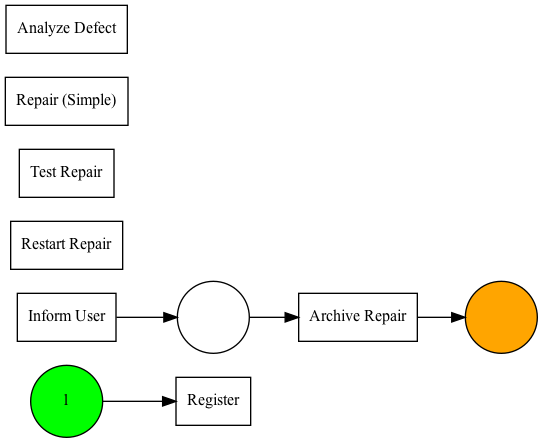

In [ ]:

## Import the petrinet visualizer object
from pm4py.algo.discovery.alpha import algorithm as alpha_miner
net, initial_marking, final_marking = alpha_miner.apply(som_sub_log7)
from pm4py.visualization.petrinet import visualizer as pn_visualizer
# Visualise 
gviz = pn_visualizer.apply(net, initial_marking, final_marking) 
pn_visualizer.view(gviz)

## Log Fitness and Precision of som_sub_log7

In [ ]:
net, im, fm = alpha_miner.apply(som_sub_log7)
fitness = replay_fitness_evaluator.apply(som_sub_log7, net, im, fm, variant=replay_fitness_evaluator.Variants.TOKEN_BASED)
simp = simplicity_evaluator.apply(net)
prec = precision_evaluator.apply(som_sub_log7, net, im, fm, variant=precision_evaluator.Variants.ETCONFORMANCE_TOKEN)
print('Fitness of Petrinet is: ', fitness['log_fitness']*100,'%')
print('Precision of Petrinet is: ', prec*100,'%')
print('Simplicity of Petrinet is: ', simp*100,'%')

replaying log with TBR, completed variants :: 100%|██████████| 64/64 [00:00<00:00, 1808.38it/s]

Fitness of Petrinet is:  100.0 %
Precision of Petrinet is:  25.213675213675213 %
Simplicity of Petrinet is:  100.0 %


## Petrinets from Alpha miner on Sub Event Log 8

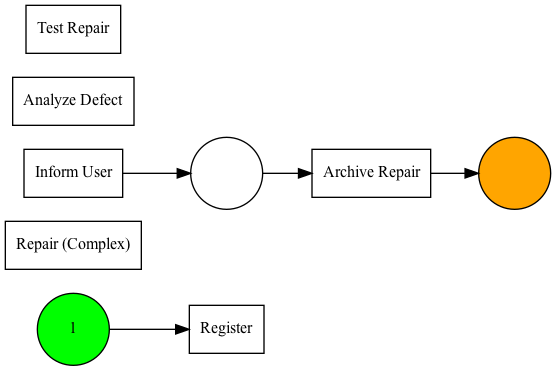

In [ ]:

## Import the petrinet visualizer object
from pm4py.algo.discovery.alpha import algorithm as alpha_miner
net, initial_marking, final_marking = alpha_miner.apply(som_sub_log8)
from pm4py.visualization.petrinet import visualizer as pn_visualizer
# Visualise 
gviz = pn_visualizer.apply(net, initial_marking, final_marking) 
pn_visualizer.view(gviz)

## Log Fitness and Precision of Sub Event log 3

In [ ]:
net, im, fm = alpha_miner.apply(som_sub_log8)
fitness = replay_fitness_evaluator.apply(som_sub_log8, net, im, fm, variant=replay_fitness_evaluator.Variants.TOKEN_BASED)
simp = simplicity_evaluator.apply(net)
prec = precision_evaluator.apply(som_sub_log8, net, im, fm, variant=precision_evaluator.Variants.ETCONFORMANCE_TOKEN)
print('Fitness of Petrinet is: ', fitness['log_fitness']*100,'%')
print('Precision of Petrinet is: ', prec*100,'%')
print('Simplicity of Petrinet is: ', simp*100,'%')

replaying log with TBR, completed variants :: 100%|██████████| 22/22 [00:00<00:00, 2815.83it/s]

Fitness of Petrinet is:  100.0 %
Precision of Petrinet is:  28.86808591522524 %
Simplicity of Petrinet is:  100.0 %


## Petrinets from Alpha miner on Sub Event Log 9

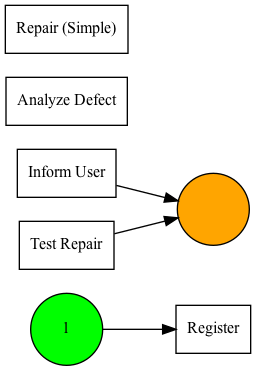

In [ ]:

## Import the petrinet visualizer object
from pm4py.algo.discovery.alpha import algorithm as alpha_miner
net, initial_marking, final_marking = alpha_miner.apply(som_sub_log9)
from pm4py.visualization.petrinet import visualizer as pn_visualizer
# Visualise 
gviz = pn_visualizer.apply(net, initial_marking, final_marking) 
pn_visualizer.view(gviz)

## Log Fitness and Precision of SubLog 9

In [ ]:
net, im, fm = alpha_miner.apply(som_sub_log9)
fitness = replay_fitness_evaluator.apply(som_sub_log9, net, im, fm, variant=replay_fitness_evaluator.Variants.TOKEN_BASED)
simp = simplicity_evaluator.apply(net)
prec = precision_evaluator.apply(som_sub_log9, net, im, fm, variant=precision_evaluator.Variants.ETCONFORMANCE_TOKEN)
print('Fitness of Petrinet is: ', fitness['log_fitness']*100,'%')
print('Precision of Petrinet is: ', prec*100,'%')
print('Simplicity of Petrinet is: ', simp*100,'%')

replaying log with TBR, completed variants :: 100%|██████████| 15/15 [00:00<00:00, 1788.06it/s]

Fitness of Petrinet is:  75.0 %
Precision of Petrinet is:  31.671554252199417 %
Simplicity of Petrinet is:  100.0 %


## Petrinets from Alpha miner on Sub Event Log 10

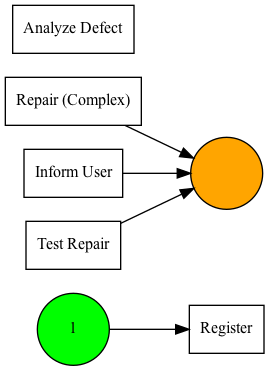

In [ ]:

## Import the petrinet visualizer object
from pm4py.algo.discovery.alpha import algorithm as alpha_miner
net, initial_marking, final_marking = alpha_miner.apply(som_sub_log10)
from pm4py.visualization.petrinet import visualizer as pn_visualizer
# Visualise 
gviz = pn_visualizer.apply(net, initial_marking, final_marking) 
pn_visualizer.view(gviz)

## Log Fitness and Precision of SubLog 10

In [ ]:
net, im, fm = alpha_miner.apply(som_sub_log10)
fitness = replay_fitness_evaluator.apply(som_sub_log10, net, im, fm, variant=replay_fitness_evaluator.Variants.TOKEN_BASED)
simp = simplicity_evaluator.apply(net)
prec = precision_evaluator.apply(som_sub_log10, net, im, fm, variant=precision_evaluator.Variants.ETCONFORMANCE_TOKEN)
print('Fitness of Petrinet is: ', fitness['log_fitness']*100,'%')
print('Precision of Petrinet is: ', prec*100,'%')
print('Simplicity of Petrinet is: ', simp*100,'%')

replaying log with TBR, completed variants :: 100%|██████████| 15/15 [00:00<00:00, 1757.88it/s]

Fitness of Petrinet is:  66.85823754789271 %
Precision of Petrinet is:  30.833333333333336 %
Simplicity of Petrinet is:  100.0 %


## Petrinets from Alpha miner on Sub Event Log 11

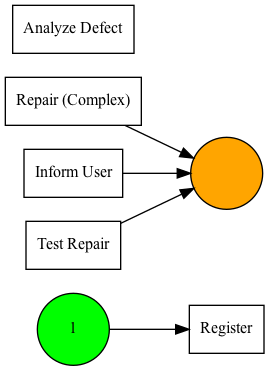

In [ ]:

## Import the petrinet visualizer object
from pm4py.algo.discovery.alpha import algorithm as alpha_miner
net, initial_marking, final_marking = alpha_miner.apply(som_sub_log11)
from pm4py.visualization.petrinet import visualizer as pn_visualizer
# Visualise 
gviz = pn_visualizer.apply(net, initial_marking, final_marking) 
pn_visualizer.view(gviz)

## Log Fitness and Precision of SubLog 12

In [ ]:
net, im, fm = alpha_miner.apply(som_sub_log11)
fitness = replay_fitness_evaluator.apply(som_sub_log11, net, im, fm, variant=replay_fitness_evaluator.Variants.TOKEN_BASED)
simp = simplicity_evaluator.apply(net)
prec = precision_evaluator.apply(som_sub_log11, net, im, fm, variant=precision_evaluator.Variants.ETCONFORMANCE_TOKEN)
print('Fitness of Petrinet is: ', fitness['log_fitness']*100,'%')
print('Precision of Petrinet is: ', prec*100,'%')
print('Simplicity of Petrinet is: ', simp*100,'%')

replaying log with TBR, completed variants :: 100%|██████████| 3/3 [00:00<00:00, 2750.36it/s]

Fitness of Petrinet is:  100.0 %
Precision of Petrinet is:  44.44444444444444 %
Simplicity of Petrinet is:  100.0 %


## Petrinets from Alpha miner on Sub Event Log 12

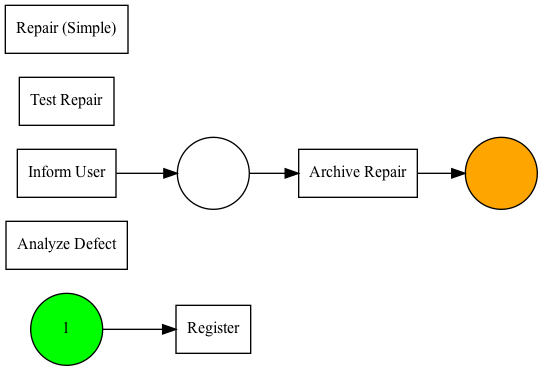

In [ ]:

## Import the petrinet visualizer object
from pm4py.algo.discovery.alpha import algorithm as alpha_miner
net, initial_marking, final_marking = alpha_miner.apply(som_sub_log12)
from pm4py.visualization.petrinet import visualizer as pn_visualizer
# Visualise 
gviz = pn_visualizer.apply(net, initial_marking, final_marking) 
pn_visualizer.view(gviz)

## Log Fitness and Precision of SubLog 12

In [ ]:
net, im, fm = alpha_miner.apply(som_sub_log12)
fitness = replay_fitness_evaluator.apply(som_sub_log12, net, im, fm, variant=replay_fitness_evaluator.Variants.TOKEN_BASED)
simp = simplicity_evaluator.apply(net)
prec = precision_evaluator.apply(som_sub_log12, net, im, fm, variant=precision_evaluator.Variants.ETCONFORMANCE_TOKEN)
print('Fitness of Petrinet is: ', fitness['log_fitness']*100,'%')
print('Precision of Petrinet is: ', prec*100,'%')
print('Simplicity of Petrinet is: ', simp*100,'%')

replaying log with TBR, completed variants :: 100%|██████████| 19/19 [00:00<00:00, 2970.58it/s]

Fitness of Petrinet is:  100.0 %
Precision of Petrinet is:  28.596950929013822 %
Simplicity of Petrinet is:  100.0 %
